In [1]:
import numpy as np
from missingpy import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# select data source:
# can be "mill" or "X"
data_source = "X"
# select corruption level:
# can be "light" or "heavy"
corr_level = "light"

# Path to uncorrupted data:
DataPath = "./data/" + data_source + "data.csv"
# Path to corrupted data:
CorruptDataPath = "./data/" + data_source + "datacorrupt" + corr_level + ".csv"


In [3]:
# Load data from a csv for analysis:
Xdata_df = pd.read_csv(DataPath)
Xdata = Xdata_df.values
del Xdata_df

# Load data with missing values from a csv for analysis:
Xdata_df = pd.read_csv(CorruptDataPath)
Xdata_Missing = Xdata_df.values
del Xdata_df



In [4]:
# Properties of data:
Xdata_length = Xdata_Missing.shape[0] # number of data points to use
n_x = Xdata_Missing.shape[1] # dimensionality of data space
ObsRowInd = np.where(np.isfinite(np.sum(Xdata_Missing,axis=1)))

NanRowInd = np.where(np.isnan(np.sum(Xdata_Missing,axis=1)))
NanIndex = np.where(np.isnan(Xdata_Missing))
Xdata_Missing_Rows = NanRowInd[0] # number of rows with missing values
# Number of missing values
NanCount = len(NanIndex[0])

In [5]:
# Zscore for reconstruction error checking:
scRecon = StandardScaler()
scRecon.fit(Xdata)

# Zscore of data produces much better results
sc = StandardScaler()
Xdata_Missing_complete = np.copy(Xdata_Missing[ObsRowInd[0],:])
# standardise using complete records:
sc.fit(Xdata_Missing_complete)
Xdata_Missing[NanIndex] = 0
Xdata_Missing = sc.transform(Xdata_Missing)
Xdata_Missing[NanIndex] = np.nan
del Xdata_Missing_complete
Xdata = sc.transform(Xdata)



# KNN Imputation fit and transform

In [6]:
imputer = KNNImputer(n_neighbors=15, weights="uniform",row_max_missing =0.8)
X_impute = imputer.fit_transform(Xdata_Missing)

/anaconda3/envs/bdl_tensorflow/lib/python3.6/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [7]:
Xdata = sc.inverse_transform(Xdata)
X_impute = sc.inverse_transform(X_impute)

Xdata = scRecon.transform(Xdata)
X_impute = scRecon.transform(X_impute)

In [8]:
ReconstructionError_l2 = (sum((X_impute[NanIndex] - Xdata[NanIndex])**2)/NanCount)**0.5
print('Reconstruction error l2 (KNN):')
print(ReconstructionError_l2)
ReconstructionError_baseline_l2 = (sum((Xdata[NanIndex])**2)/NanCount)**0.5
print('Reconstruction error l2 (replace with mean):')
print(ReconstructionError_baseline_l2)

Reconstruction error l2 (KNN):
0.10331782610114061
Reconstruction error l2 (replace with mean):
1.0010680700177845


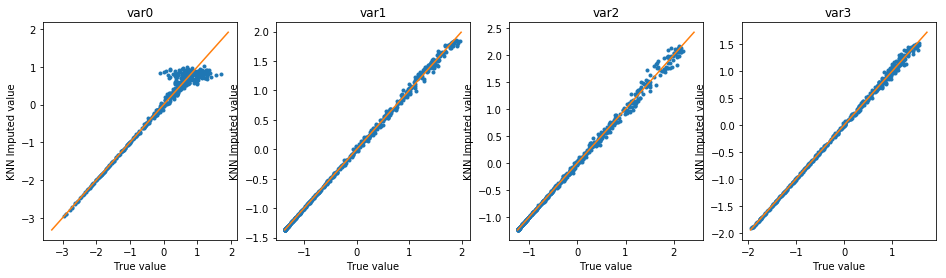

In [9]:
fig_h, subplot_grid = plt.subplots(nrows=1, ncols=4,  figsize=(16,4)) 
for i in range(4):
    var_i = i 
    min_i = np.min(Xdata[:,var_i])
    max_i = np.max(Xdata[:,var_i])
    subplot_grid[i].plot(Xdata[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],
                         X_impute[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],'.')
    subplot_grid[i].plot([min_i, max_i], [min_i, max_i]) #the line
    subplot_grid[i].set_xlabel('True value')
    subplot_grid[i].set_ylabel('KNN Imputed value')
    subplot_grid[i].set_title('var' + str(i))